## 概要

環境が変わる時、どのようなダイナミクスによってpriorが変わったことを認識しているのか？を調べる。

In [1]:
import os
import math

import matplotlib
import numpy as np
import sys
import scipy
import yaml

from sklearn.metrics import mean_squared_error

sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from matplotlib import cm

from slow_reservoir.model import RNN, RNNSimple
from slow_reservoir.dataset.dynamic_state import State

%matplotlib inline

In [2]:
sigma_sq = 0.5

In [3]:
def make_signal_for_prior(time_length, mu_p, sigma_p, uncertainty=0.5, g=1.25):
    input_signals = np.zeros([1, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    
    state = State(mu=mu_p, sigma=sigma_p)
    
    for i in range(1):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            true_signal = state()
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            
            signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        
    return input_signals

In [64]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220428_1/20220428_1.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()



model_name:  20220428_1


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [65]:
mu_p_list = np.linspace(-0.5, 0.5, 11)
sigma_p_list = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

In [66]:
sigma_l = math.sqrt(1/1.25) * 0.5
mu_p_list = []
sigma_p_list = []

neural_states = np.zeros((300, 30, 200))
reservoir_states = np.zeros((300, 30, 50))
for i in range(300):
    mu_p = np.random.rand()-0.5
    sigma_p = np.random.rand()*0.8
    mu_p_list.append(mu_p)
    sigma_p_list.append(sigma_p)
    input_signal = make_signal_for_prior(
        time_length=50, 
        mu_p=mu_p,
        sigma_p=sigma_p,
        uncertainty=0.5,
        g=1.25,
    )
    inputs = torch.from_numpy(input_signal).float()                                 
    inputs = inputs.to(device) 
    hidden_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['SIZE']))
    reservoir_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['RESERVOIR']))
         
    hidden = torch.from_numpy(hidden_np).float()                               
    hidden = hidden.to(device) 
    reservoir = torch.from_numpy(reservoir_np).float()
    reservoir = reservoir.to(device)
    hidden_list, _, _, reservoir_list = model(inputs, hidden, reservoir, 50) 
        
    neural_dynamics = hidden_list.cpu().detach().numpy()   
    reservoir_dynamics = reservoir_list.cpu().detach().numpy()
        
    neural_states[i] = neural_dynamics[0, -30:]
    reservoir_states[i] = reservoir_dynamics[0, -30:]

In [67]:
neural_states_all = neural_states.reshape(300*30, 200)
reservoir_states_all = reservoir_states.reshape(300*30, 50)

In [68]:
os.makedirs('results/20220531', exist_ok=True)

## main network

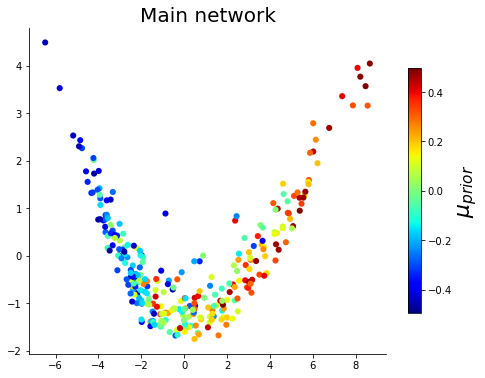

In [69]:
pca_main = PCA(n_components=3)
pca_main.fit(neural_states_all)

trajectory = pca_main.transform(neural_states_all)

fig = plt.figure(figsize=(8, 6))

internal_dynamics = plt.scatter(
    trajectory[25::30, 0], 
    trajectory[25::30, 1],  
    c=mu_p_list,
    cmap=cm.jet, 
    s=150, marker='.', lw=0, zorder=2,
)

cbar = fig.colorbar(internal_dynamics, shrink = 0.75)
cbar.set_label(r'$\mu_{prior}$', fontsize=22)

plt.title('Main network', fontsize=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.savefig('results/20220531/main_mu.png', dpi=200)

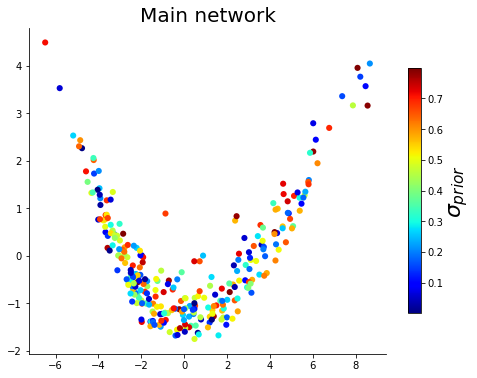

In [70]:
fig = plt.figure(figsize=(8, 6))

internal_dynamics = plt.scatter(
    trajectory[25::30, 0], 
    trajectory[25::30, 1],  
    c=sigma_p_list,
    cmap=cm.jet, 
    s=150, marker='.', lw=0, zorder=2,
)

cbar = fig.colorbar(internal_dynamics, shrink = 0.75)
cbar.set_label(r'$\sigma_{prior}$', fontsize=22)

plt.title('Main network', fontsize=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.savefig('results/20220531/main_sigma.png', dpi=200)

## sub network

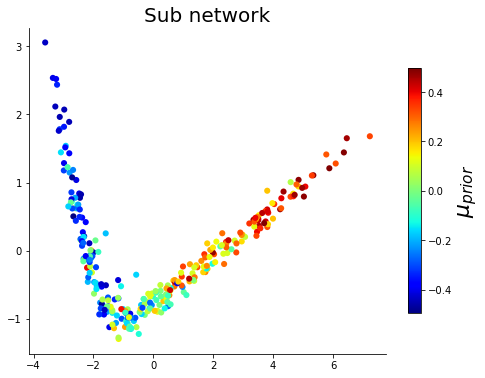

In [71]:
pca_sub = PCA(n_components=3)
pca_sub.fit(reservoir_states_all)

trajectory = pca_sub.transform(reservoir_states_all)

fig = plt.figure(figsize=(8, 6))

internal_dynamics = plt.scatter(
    trajectory[25::30, 0], 
    trajectory[25::30, 1],  
    c=mu_p_list,
    cmap=cm.jet, 
    s=150, marker='.', lw=0, zorder=2,
)

cbar = fig.colorbar(internal_dynamics, shrink = 0.75)
cbar.set_label(r'$\mu_{prior}$', fontsize=22)
plt.title('Sub network', fontsize=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.savefig('results/20220531/sub_mu.png', dpi=200)

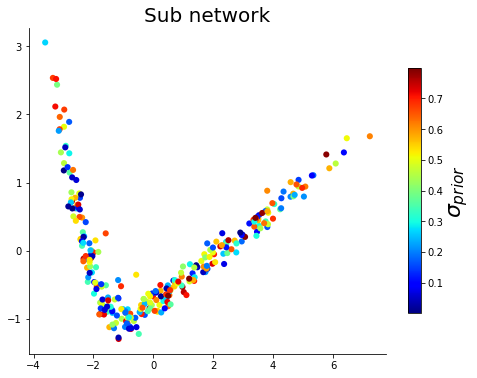

In [72]:
fig = plt.figure(figsize=(8, 6))

internal_dynamics = plt.scatter(
    trajectory[25::30, 0], 
    trajectory[25::30, 1],  
    c=sigma_p_list,
    cmap=cm.jet, 
    s=150, marker='.', lw=0, zorder=2,
)

cbar = fig.colorbar(internal_dynamics, shrink = 0.75)
cbar.set_label(r'$\sigma_{prior}$', fontsize=22)

plt.title('Sub network', fontsize=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.savefig('results/20220531/sub_sigma.png', dpi=200)

## 途中で切り替わる環境を考える

In [73]:
def make_signal(N, time_length, state_list, uncertainty=0.5):
    input_signals = np.zeros([N, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    sigma_sq = 0.5
    g = 1.25
    target_list = np.zeros([N, 400])
    signal_mu_list = np.zeros((N, time_length))
    true_signal_list = np.zeros((N, time_length))
    
    for i in range(N):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            if t <= 50:
                true_signal = state_list[0]()
            else:
                true_signal = state_list[1]()
            true_signal_list[i, t] = true_signal
            
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            signal_mu_list[i, t] = signal_mu
            
            signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        
    return input_signals, true_signal_list, signal_mu_list

In [74]:
state_list = [
    State(mu=0.4, sigma=0.8),
    State(mu=-0.4, sigma=0.1),
]

In [75]:
sample_num = 1
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=100, 
    uncertainty=0.5,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))

# 時間スケールに差があるモデル
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_slow, prior_list, reservoir_list = model(inputs, hidden, reservoir, 100)                                                       


In [76]:
trajectory_main = pca_main.transform(hidden_list.detach().numpy()[0])

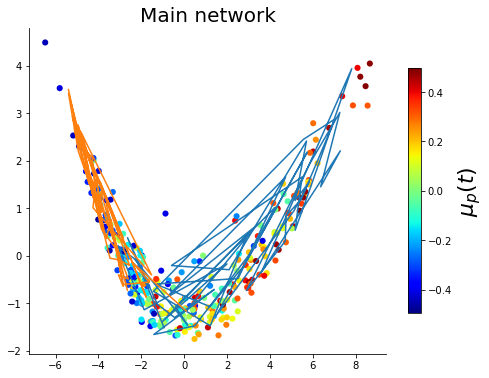

In [77]:
pca_main = PCA(n_components=3)
pca_main.fit(neural_states_all)

trajectory = pca_main.transform(neural_states_all)

fig = plt.figure(figsize=(8, 6))

internal_dynamics = plt.scatter(
    trajectory[25::30, 0], 
    trajectory[25::30, 1],  
    c=mu_p_list,
    cmap=cm.jet, 
    s=150, marker='.', lw=0, zorder=2,
)

plt.plot(
    trajectory_main[:51, 0],
    trajectory_main[:51, 1],
)
plt.plot(
    trajectory_main[50:, 0],
    trajectory_main[50:, 1],
)

cbar = fig.colorbar(internal_dynamics, shrink = 0.75)
cbar.set_label(r'$\mu_p(t)$', fontsize=22)

plt.title('Main network', fontsize=20)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.savefig('results/20220531/transition_main.png', dpi=200)

In [78]:
trajectory_sub = pca_sub.transform(reservoir_list.detach().numpy()[0])

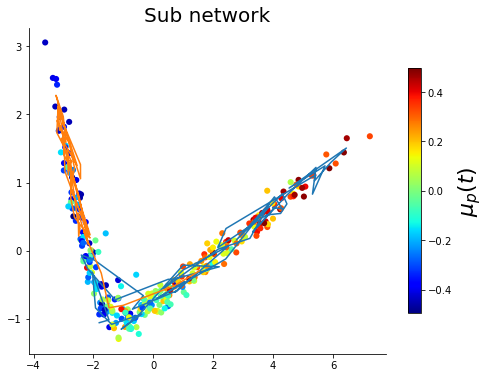

In [79]:
pca_sub = PCA(n_components=3)
pca_sub.fit(reservoir_states_all)

trajectory = pca_sub.transform(reservoir_states_all)

fig = plt.figure(figsize=(8, 6))

internal_dynamics = plt.scatter(
    trajectory[25::30, 0], 
    trajectory[25::30, 1],  
    c=mu_p_list,
    cmap=cm.jet, 
    s=150, marker='.', lw=0, zorder=2,
)

plt.plot(
    trajectory_sub[:51, 0],
    trajectory_sub[:51, 1],
)
plt.plot(
    trajectory_sub[50:, 0],
    trajectory_sub[50:, 1],
)

cbar = fig.colorbar(internal_dynamics, shrink = 0.75)
cbar.set_label(r'$\mu_p(t)$', fontsize=22)

plt.title('Sub network', fontsize=20)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.savefig('results/20220531/transition_sub.png', dpi=200)

In [80]:
state_list = [
    State(mu=0.3, sigma=0.2),
    State(mu=-0.3, sigma=0.2),
]

In [81]:
sample_num = 1
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=100, 
    uncertainty=0.5,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))

# 時間スケールに差があるモデル
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_slow, prior_list, reservoir_list = model(inputs, hidden, reservoir, 100)                                                       


In [82]:
trajectory_main = pca_main.transform(hidden_list.detach().numpy()[0])

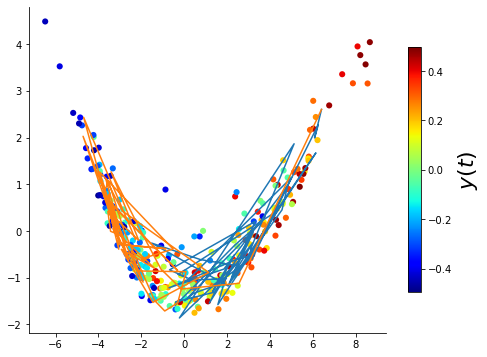

In [83]:
pca_main = PCA(n_components=3)
pca_main.fit(neural_states_all)

trajectory = pca_main.transform(neural_states_all)

fig = plt.figure(figsize=(8, 6))

internal_dynamics = plt.scatter(
    trajectory[25::30, 0], 
    trajectory[25::30, 1],  
    c=mu_p_list,
    cmap=cm.jet, 
    s=150, marker='.', lw=0, zorder=2,
)

plt.plot(
    trajectory_main[:51, 0],
    trajectory_main[:51, 1],
)
plt.plot(
    trajectory_main[50:, 0],
    trajectory_main[50:, 1],
)

cbar = fig.colorbar(internal_dynamics, shrink = 0.75)
cbar.set_label(r'$y(t)$', fontsize=22)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

In [84]:
trajectory_sub = pca_sub.transform(reservoir_list.detach().numpy()[0])

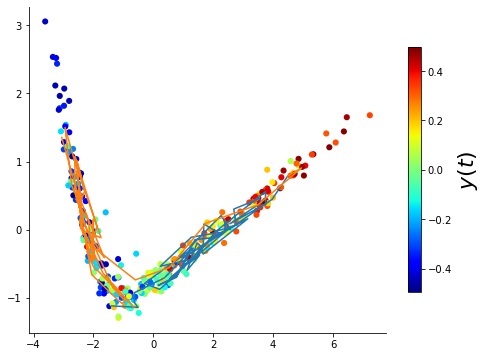

In [85]:
pca_sub = PCA(n_components=3)
pca_sub.fit(reservoir_states_all)

trajectory = pca_sub.transform(reservoir_states_all)

fig = plt.figure(figsize=(8, 6))

internal_dynamics = plt.scatter(
    trajectory[25::30, 0], 
    trajectory[25::30, 1],  
    c=mu_p_list,
    cmap=cm.jet, 
    s=150, marker='.', lw=0, zorder=2,
)

plt.plot(
    trajectory_sub[:51, 0],
    trajectory_sub[:51, 1],
)
plt.plot(
    trajectory_sub[50:, 0],
    trajectory_sub[50:, 1],
)

cbar = fig.colorbar(internal_dynamics, shrink = 0.75)
cbar.set_label(r'$y(t)$', fontsize=22)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

## 2つの環境を行き来する場合の振る舞い

In [86]:
freq = []
for i in range(100):
    for j in range(np.random.randint(4)):
        freq.append(0)
    for j in range(np.random.randint(4)):
        freq.append(1)

In [87]:
def make_signal(N, time_length, state_list, uncertainty=0.5, interval=10):
    input_signals = np.zeros([N, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    sigma_sq = 0.5
    g = 1.25
    target_list = np.zeros([N, 400])
    signal_mu_list = np.zeros((N, time_length))
    true_signal_list = np.zeros((N, time_length))
    
    for i in range(N):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            # true_signal = state_list[freq[t]]()
            if (t // interval) % 2:
                true_signal = state_list[0]()
            else:
                true_signal = state_list[1]()
            true_signal_list[i, t] = true_signal
            
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            signal_mu_list[i, t] = signal_mu
            
            signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        
    return input_signals, true_signal_list, signal_mu_list

In [98]:
state_list = [
    State(mu=0.5, sigma=0.15),
    State(mu=-0.5, sigma=0.15),
]

sample_num = 1
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=100, 
    uncertainty=0.5,
    interval=5,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))

# 時間スケールに差があるモデル
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_slow, prior_list, reservoir_list = model(inputs, hidden, reservoir, 100)                                                       


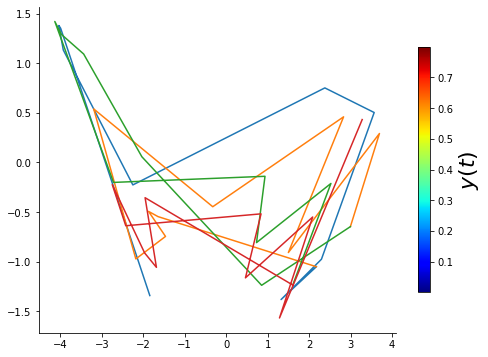

In [99]:
trajectory_main = pca_main.transform(hidden_list.detach().numpy()[0])

pca_main = PCA(n_components=3)
pca_main.fit(neural_states_all)

trajectory = pca_main.transform(neural_states_all)

fig = plt.figure(figsize=(8, 6))

"""
internal_dynamics = plt.scatter(
    trajectory[25::30, 0], 
    trajectory[25::30, 1],  
    c=mu_p_list,
    cmap=cm.jet, 
    s=150, marker='.', lw=0, zorder=2,
)
"""

plt.plot(
    trajectory_main[:10, 0],
    trajectory_main[:10, 1],
)
plt.plot(
    trajectory_main[9:20, 0],
    trajectory_main[9:20, 1],
)
plt.plot(
    trajectory_main[19:30, 0],
    trajectory_main[19:30, 1],
)
plt.plot(
    trajectory_main[29:40, 0],
    trajectory_main[29:40, 1],
)

cbar = fig.colorbar(internal_dynamics, shrink = 0.75)
cbar.set_label(r'$y(t)$', fontsize=22)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

In [100]:
len(trajectory_main[:10, 0])

10

In [101]:
trajectory_sub = pca_sub.transform(reservoir_list.detach().numpy()[0])

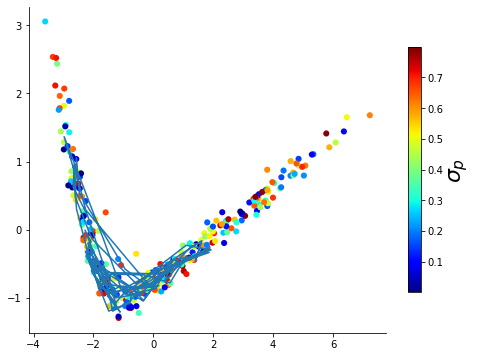

In [102]:
pca_sub = PCA(n_components=3)
pca_sub.fit(reservoir_states_all)

trajectory = pca_sub.transform(reservoir_states_all)

fig = plt.figure(figsize=(8, 6))

internal_dynamics = plt.scatter(
    trajectory[25::30, 0], 
    trajectory[25::30, 1],  
    c=sigma_p_list,
    cmap=cm.jet, 
    s=150, marker='.', lw=0, zorder=2,
)

plt.plot(
    trajectory_sub[:, 0],
    trajectory_sub[:, 1],
)
# plt.plot(
#     trajectory_sub[50:, 0],
#     trajectory_sub[50:, 1],
# )

cbar = fig.colorbar(internal_dynamics, shrink = 0.75)
cbar.set_label(r'$\sigma_p$', fontsize=22)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

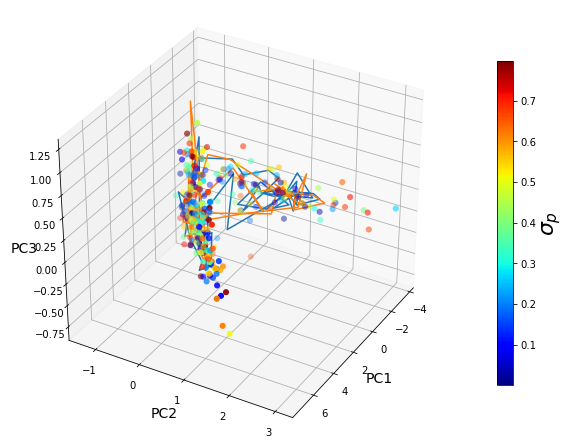

In [96]:
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.view_init(elev=35, azim=30)

# 軸ラベルの設定
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
ax.set_zlabel('PC3', fontsize=14)

    
internal_dynamics = ax.scatter(
    trajectory[25::30, 0], 
    trajectory[25::30, 1],  
    trajectory[25::30, 2], 
    c=sigma_p_list,
    cmap=cm.jet, 
    s=150, marker='.', lw=0, zorder=2,
)

plt.plot(
    trajectory_sub[:51, 0],
    trajectory_sub[:51, 1],
    trajectory_sub[:51, 2],
)
plt.plot(
    trajectory_sub[50:, 0],
    trajectory_sub[50:, 1],
    trajectory_sub[50:, 2],
)

cbar = fig.colorbar(internal_dynamics, shrink = 0.75)
cbar.set_label(r'$\sigma_p$', fontsize=22)

plt.show()


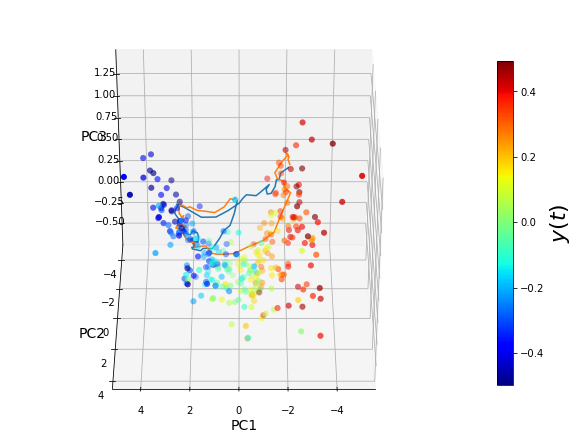

In [58]:
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.view_init(elev=35, azim=90)

# 軸ラベルの設定
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
ax.set_zlabel('PC3', fontsize=14)

    
internal_dynamics = ax.scatter(
    trajectory[25::30, 0], 
    trajectory[25::30, 1],  
    trajectory[25::30, 2], 
    c=mu_p_list,
    cmap=cm.jet, 
    s=150, marker='.', lw=0, zorder=2,
)

plt.plot(
    trajectory_sub[:50, 0],
    trajectory_sub[:50, 1],
    trajectory_sub[:50, 2],
)
plt.plot(
    trajectory_sub[50:, 0],
    trajectory_sub[50:, 1],
    trajectory_sub[50:, 2],
)

cbar = fig.colorbar(internal_dynamics, shrink = 0.75)
cbar.set_label(r'$y(t)$', fontsize=22)

plt.show()
